# Lab 06 - Data Preprocessing I

Name: Qixiao Zhu
Class: CSCI 349 - Intro to Data Mining  
Semester: Spring 2023
Instructor: Brian King

---
# Objectives
* Experience the "joy" that is data munging. Munge, munge, munge!
* Start dealing with noisy, unclean, real-world data
* Work with times and dates in your data

## Pair programming
Don't forget that pair programming is allowed and even encouraged on these labs moving forward.

# Introduction
As you learned in class, data cleaning represents a large part of the work of the data scientist.  You are going to download a real-world dataset, and do some preliminary cleaning, EDA, and reporting.

---
# Preparing for your lab

Do each of the following...

* Modify the header cell above with your name(s).
* If you haven't yet, create a new folder at the same level as your labs and hw folder you created, called `data`.
    * This folder will store the data that you are working with through the semester. Sometimes the data we work with can be downloaded directly from an online URL, and other times (such as this exercise), the data will need to be downloaded from public repositories locally onto your laptop. And worse yet, most data are not cleaned and tidied up for you to play with!

---
## The Pennsylvania State Climatologist Database

Penn State has an excellent public database of weather observations collected from a wide range of stations scattered throughout the state. Some of them go back to the 1940s. For this lab, we're going to explore one of those datasets – Williamsport, PA.

Go to the [The Pennsylvania State Climatologist](http://climate.met.psu.edu). From this page:
* Select **Data**
* Select **Data Archive**
* For **Select a network** select **FAA Hourly**.
* You are going to investigate the weather observations *Williamsport, PA*, whose FAA code is **KIPT**. Select it.

Now you need to select the range of observations and variables we're interested in. Enter the following:

* Start and End Dates: **2000-01-01** to **2022-12-31**.
* Select EVERY attribute to download (from Date/Time, Number of observations… etc… right through Max Wind Speed).
* Output file type should be a CSV file
* Select Yes to include Metadata. (Metadata is information about data. This usually contains valuable information, and you almost always want to retain this information unless you are provided with an explicit *schema*, which we are not.

**Click Submit.**

Download the data (which will most likely place your data into your Downloads folder.)  It'll be a long filename. That's fine. I usually always add the suffix "_raw" to indicate this is the raw data that I'm working with from my source. *Never lose track of your original dataset.*

You are not done. Move that file over to your `data` directory you created (which should be at the same directly level as your `labs` directory.) If you placed the .csv file in the correct place, then your path should be:

`../data/faa_hourly-KIPT_20000101-20221231_raw.csv`




In [1886]:
import math
# This magic command just allows the autocomplete <TAB>
# feature to work properly.
%config Completer.use_jedi = False

In [1887]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

print(pd.show_versions())


INSTALLED VERSIONS
------------------
commit           : 8dab54d6573f7186ff0c3b6364d5e4dd635ff3e7
python           : 3.9.16.final.0
python-bits      : 64
OS               : Windows
OS-release       : 10
Version          : 10.0.19045
machine          : AMD64
processor        : AMD64 Family 25 Model 80 Stepping 0, AuthenticAMD
byteorder        : little
LC_ALL           : en_US.UTF-8
LANG             : en_US.UTF-8
LOCALE           : Chinese (Simplified)_China.utf8

pandas           : 1.5.2
numpy            : 1.23.5
pytz             : 2022.7
dateutil         : 2.8.2
setuptools       : 65.6.3
pip              : 22.3.1
Cython           : None
pytest           : None
hypothesis       : None
sphinx           : None
blosc            : None
feather          : None
xlsxwriter       : None
lxml.etree       : 4.9.1
html5lib         : None
pymysql          : None
psycopg2         : None
jinja2           : 3.1.2
IPython          : 8.7.0
pandas_datareader: None
bs4              : 4.11.1
bottleneck   

---
**1)**	 [P] Use pandas to read in your data file you downloaded above, which you should have placed in your data directory. Call the data frame `df_temps`.  Read in the entire dataset, however, be sure to ignore the first 16 rows from the input (HINT: use the `skiprows=` option!)

**NOTE:** ALWAYS BE SURE TO LOOK AT YOUR ACTUAL DATA AS PLAIN TEXT BEFORE TRYING TO READ IN A RAW DATASET! JUST BECAUSE A DATASET HAS A `.csv` EXTENSION DOES NOT MEAN THAT YOU CAN RELY ON EVERY ROW BEING A PROPERLY FORMATTED ROW! For instance, notice that the header row is scattered throughout your data! Notice that you have some extra columns at the end that are consistently empty! The inexperienced data scientists are tempted to manually edit the file to make it easy to read. *NO. WRONG! BAD DATA SCIENTIST!*

>**Never change your raw data.**
>
> Write your Python cleaning code to always work with raw, uncleaned data. Why? In practice, your data file may be huge. You may need to repeatedly grab fresh data, and those data will only have the same issues. Do you really want to repeat your manual editing silliness every time you have a fresh file? No! It may take a bit more work up front, but ALWAYS strive to write code to preprocess every aspect of your raw data file! It will always save you work later!

In [1888]:
# ANSWER

df_temps = pd.read_csv("../data/faa_hourly-KIPT_20000101-20221231_raw.csv", skiprows=16)

---
**2)**	Report the general structure of the data frame using `df_temps.info()`. Notice any column that is read in as a plain `object` type. You should have one column with this problem.

In [1889]:
# ANSWER

df_temps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199201 entries, 0 to 199200
Data columns (total 14 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Date/Time (GMT)                199201 non-null  object 
 1   Number of Observations (n/a)   199201 non-null  int64  
 2   Average Temp (F)               198189 non-null  float64
 3   Max Temp (F)                   198189 non-null  float64
 4   Min Temp (F)                   198189 non-null  float64
 5   Average Dewpoint Temp (F)      198067 non-null  float64
 6   1 Hour Precip (in)             32345 non-null   float64
 7   Max Wind Gust (mph)            26839 non-null   float64
 8   Average Relative Humidity (%)  193828 non-null  float64
 9   Average Wind Speed (mph)       198638 non-null  float64
 10  Average Station Pressure (mb)  198852 non-null  float64
 11  Average Wind Direction (deg)   165309 non-null  float64
 12  Max Wind Speed (mph)          

---
This is a pretty good dataset with lots of real problems! It gives you a chance to understand how important it is to select the smallest, yet most accurate data type for every variable. This is particularly true with respect to your memory footprint. With enormous data involving millions of records, you often need to perform various paging exercises to load in chunks of data into memory, substantially slowing down the machine learning methods. In other words, the more data you can fit in memory, the better! (In reality, the above is quoting a relatively small amount of memory. But, it's never too early to develop good habits!)


---
**3)**	[P] Read about the `memory_usage()` method of pandas data frames. Then, report the total memory in bytes for each variable of df_temps. Set the parameter drop=True, to get the most accurate assessment of your total memory usage.

In [1890]:
# ANSWER

df_temps.memory_usage(deep=True)

Index                                 128
Date/Time (GMT)                  15139276
Number of Observations (n/a)      1593608
Average Temp (F)                  1593608
Max Temp (F)                      1593608
Min Temp (F)                      1593608
Average Dewpoint Temp (F)         1593608
1 Hour Precip (in)                1593608
Max Wind Gust (mph)               1593608
Average Relative Humidity (%)     1593608
Average Wind Speed (mph)          1593608
Average Station Pressure (mb)     1593608
Average Wind Direction (deg)      1593608
Max Wind Speed (mph)              1593608
Unnamed: 13                       1593608
dtype: int64

---
**4)**	Report the total memory required for the data frame in MB. (Just sum the previous answer and correct your units accordingly)

In [1891]:
# ANSWER

original_memory = df_temps.memory_usage(deep=True).sum() / (1024**2)
print("total memory: " + str(original_memory.round(2)) + " MB")

total memory: 34.2 MB


---
**5)**	[P] You have a rather annoying extra column that was read in in the last column position. (Look closely at the output of `info()` above!) You should always confirm that it's garbage before deleting it. Write the single line of code that reports the count of valid values in the last column (HINT: `count()`)

 

In [1892]:
# ANSWER

df_temps.iloc[:, -1].count()

0

---
**6)**	Drop that last column from `df_temps`.

In [1893]:
# ANSWER

df_temps = df_temps.drop(columns=df_temps.columns[-1])

---
**7)**	[M] Look over the data type column in the `info()` output. ALWAYS pay attention to the types of each variable. In particular, pay attention to the variables that are read in as `object` type. This implies that pandas did not have enough confidence to convert the type itself, and you need to do it. Are there any `object` types? If so what? What format are the data in that column(s)?

In [1894]:
# ANSWER

df_temps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199201 entries, 0 to 199200
Data columns (total 13 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Date/Time (GMT)                199201 non-null  object 
 1   Number of Observations (n/a)   199201 non-null  int64  
 2   Average Temp (F)               198189 non-null  float64
 3   Max Temp (F)                   198189 non-null  float64
 4   Min Temp (F)                   198189 non-null  float64
 5   Average Dewpoint Temp (F)      198067 non-null  float64
 6   1 Hour Precip (in)             32345 non-null   float64
 7   Max Wind Gust (mph)            26839 non-null   float64
 8   Average Relative Humidity (%)  193828 non-null  float64
 9   Average Wind Speed (mph)       198638 non-null  float64
 10  Average Station Pressure (mb)  198852 non-null  float64
 11  Average Wind Direction (deg)   165309 non-null  float64
 12  Max Wind Speed (mph)          

In [1895]:
df_temps["Date/Time (GMT)"].head()

0    2000-01-01 00:00:00
1    2000-01-01 01:00:00
2    2000-01-01 02:00:00
3    2000-01-01 03:00:00
4    2000-01-01 04:00:00
Name: Date/Time (GMT), dtype: object

**ANSWER**

I see that the Date/Time (GMT) column is of the type object. Its format is date and time.

---
**8)**	[P] How many NaN values are in each variable? (NOTE: Leave the NaN fields alone! The fact that they are missing is IMPORTANT! And, leave the date/time variable in the first column alone. Dates are very common in data, and it is important that you represent dates as actual date types. We'll deal with that shortly.)

In [1896]:
# ANSWER

df_temps.isna().sum()

Date/Time (GMT)                       0
Number of Observations (n/a)          0
Average Temp (F)                   1012
Max Temp (F)                       1012
Min Temp (F)                       1012
Average Dewpoint Temp (F)          1134
1 Hour Precip (in)               166856
Max Wind Gust (mph)              172362
Average Relative Humidity (%)      5373
Average Wind Speed (mph)            563
Average Station Pressure (mb)       349
Average Wind Direction (deg)      33892
Max Wind Speed (mph)                563
dtype: int64

---
**9)**	[P] Report the NaN output as a percentage of the total number of values that are missing for each variable

In [1897]:
# ANSWER

(df_temps.isna().sum() / df_temps.isna().sum().sum() * 100)\
    .round(2).astype(str) + "%"

Date/Time (GMT)                    0.0%
Number of Observations (n/a)       0.0%
Average Temp (F)                  0.26%
Max Temp (F)                      0.26%
Min Temp (F)                      0.26%
Average Dewpoint Temp (F)          0.3%
1 Hour Precip (in)               43.44%
Max Wind Gust (mph)              44.87%
Average Relative Humidity (%)      1.4%
Average Wind Speed (mph)          0.15%
Average Station Pressure (mb)     0.09%
Average Wind Direction (deg)      8.82%
Max Wind Speed (mph)              0.15%
dtype: object

---
**10)**	[PM] Report the number of observations that are complete, meaning, they have NO missing variable in the observation. Report this as a raw number and as a percentage of the total number of observations. Then, clearly state why this is NOT a problem to be concerned about for this particular dataset. (HINT: Which variable(s) have most of the missing data and why?)


In [1898]:
# ANSWER

df_temps.notna().all().sum()

2

In [1899]:
print(str((df_temps.notna().all().sum() /
           df_temps.shape[1] * 100).round(2)) + "%")

15.38%


**ANSWER:**

it's to be expected. Most hours over a year do not have recordable wind or precipitation.

---
**11)**	[P] Look over your data types. By default, most of the time pandas will convert your integer types to a 64-bit integer, and floating point types will use double precision numbers. You can do far better. Read over the `pd.to_numeric()` function. Did you notice the parameter called `downcast`? Go back and read about this parameter. Downcast your types accordingly. Then, look over the output of `info()` and report your latest memory usage in MB.





In [1923]:
# ANSWER

df_temps["Number of Observations (n/a)"] = \
    pd.to_numeric(df_temps["Number of Observations (n/a)"], downcast="integer")
df_temps.loc[:, "Average Temp (F)" :] =  \
    df_temps.loc[:, "Average Temp (F)" :].apply(pd.to_numeric, downcast="float")
df_temps.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 191209 entries, 2001-01-01 00:00:00 to 2022-12-31 23:00:00
Data columns (total 12 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Number of Observations (n/a)   191209 non-null  int8   
 1   Average Temp (F)               190237 non-null  float32
 2   Max Temp (F)                   190237 non-null  float32
 3   Min Temp (F)                   190237 non-null  float32
 4   Average Dewpoint Temp (F)      190116 non-null  float32
 5   1 Hour Precip (in)             29587 non-null   float32
 6   Max Wind Gust (mph)            24470 non-null   float32
 7   Average Relative Humidity (%)  185877 non-null  float32
 8   Average Wind Speed (mph)       190646 non-null  float32
 9   Average Station Pressure (mb)  190879 non-null  float32
 10  Average Wind Direction (deg)   160993 non-null  float32
 11  Max Wind Speed (mph)           190646 non-null  float32
d

---
**12)**	[P] How much did our memory footprint improve? (Show the total memory usage using `deep=True`). Report the total memory usage in MB, and report the percentage improvement.

In [1901]:
# ANSWER

new_memory = df_temps.memory_usage(deep=True).sum() / (1024**2)
print("new memory: " + str(new_memory.round(2)) + " MB")
print("percentage improved: " +
      str(((original_memory - new_memory) / original_memory * 100).round(2)) + "%")

new memory: 22.99 MB
percentage improved: 32.78%


---
# Data Transformations with Dates

It is very common to deal with dates in data. Unfortunately, few organizations around the world have agreed to one format for universally representing dates in data. Adding to the complexity are time zones that you must deal with. We'll discuss that later. Let's suppose we wanted to represent February 6, 2023, depending on your location in the world, the date might be stored in the data as:

* 02/06/2023
* 06/02/23
* 06/02/2023
* 06.02.2023
* 2023-Feb-06
* February 06, 2023
* 06-Feb-2023
* 20230206

And, there are others! Insanity! Can't we all just get along??? (Apparently not, especially when it comes to dates and times, and currencies, and food, and etc.) The fact is that these are all acceptable formats for dates. Sometimes pandas can do a pretty good just detecting date fields. However, as we noticed in this case, not always. It's up to YOU to make sure you convert your data to the most appropriate type.

Generally speaking, when your data consists of a series of observations recorded over time, we refer to these types of data as **time series** data. And, usually every observation will have a time or a date variable that identifies when the observation was recorded.

[Time series / date functionality](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html) has just about everything you need to deal with dates with time series data. It has far more than you'll need   . As with most of the API with core packages like pandas, there is a LOT to absorb, and at best, you'll just become familiar with how to find the answers you are after in their documentation!

This portion of the lab will help you learn how to confidently work with dates and times in data.



---
**13)**	[M] There are four primary classes in pandas for working with dates and times? Consider the Scalar Class for each, and state what concept each is representing.

**ANSWER:**

From https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html:

Timestamp: A specific date and time with timezone support. Similar to datetime.datetime from the standard library.

Timedelta: An absolute time duration. Similar to datetime.timedelta from the standard library.

Period: A span of time defined by a point in time and its associated frequency.

DateOffset: A relative time duration that respects calendar arithmetic. Similar to dateutil.relativedelta.relativedelta from the dateutil package.

---
**14)**	[M] For each above, state the primary creation method used to create each type of data

**ANSWER:**

Timestamp: to_datetime or date_range

Timedelta: to_timedelta or timedelta_range

Period: Period or period_range

DateOffset: DateOffset

---
**15)**	[P] Create a Timestamp object from the string "07/04/19", which is a date representing July 4, 2019. Store the object as `d1` and show it.

In [1902]:
# ANSWER

d1 = pd.to_datetime("07/04/19")
d1

Timestamp('2019-07-04 00:00:00')

---
**16)**	[P] Using `d1` and string formatting codes, print the string from `d1`:

"Today's date is Thursday, July 4, 2019". 

In [1903]:
# ANSWER

# ChatGPT:
print("Today's date is {0:%A}, {0:%B} {0:%#d}, {0:%Y}.".format(d1))

Today's date is Thursday, July 4, 2019.


---
**17)**	[P] Create another Timestamp object representing Sept 7, 2019 at 3pm, called `d2`. Report it

In [1904]:
# ANSWER

d2 = pd.to_datetime("Sept 7, 2019 at 3pm")
d2

Timestamp('2019-09-07 15:00:00')

---
**18)**	[P] Subtract `d1` from the value of `d2` (i.e `d2 - d1`) and report the difference as the number of days and seconds between these two. Also report the difference as total seconds.  (NOTE: The difference should be 65 days, 54000 seconds. Or 5670000 total seconds.)

In [1905]:
# ANSWER
import math

days = (d2 - d1).total_seconds() / (24*3600)
seconds = (days - math.floor(days)) * (24*3600)
days = math.floor(days)
print("difference in days and seconds: " +
      str(days) + " days and " + str(int(seconds)) + " seconds")
print("difference in seconds: " + str(int((d2-d1).total_seconds())))

difference in days and seconds: 65 days and 54000 seconds
difference in seconds: 5670000


---
**19)**	[P] Create a new Timestamp object from the string "2019-07-01 08:30pm", but, localize the time stamp to represent the time in the US Eastern Time Zone. Store the result as `d3` and output it.

In [1906]:
# ANSWER

# ChatGPT:
d3 = pd.to_datetime("2019-07-01 08:30pm").tz_localize("US/Eastern")
d3

Timestamp('2019-07-01 20:30:00-0400', tz='US/Eastern')

---
**20)**	[P] Show time represented by `d3`, but converted to the US / Pacific Time Zone. The time reported should be three hours earlier than EST shown in the previous question.

In [1907]:
# ANSWER

d3.tz_convert("US/Pacific")

Timestamp('2019-07-01 17:30:00-0700', tz='US/Pacific')

---
**21)**	[P] Create a Timestamp object representing right now, stored as `ts_now`. Report the result.


In [1908]:
# ANSWER

# ChatGPT:
ts_now = pd.Timestamp.now()
ts_now

Timestamp('2023-02-12 22:56:12.760152')

---
**22)**	[P] Create a Timedelta object representing 1 hour, stored as `td_hour`. Report the result.

In [1909]:
# ANSWER

# ChatGPT:
td_hour = pd.Timedelta(hours=1)
td_hour

Timedelta('0 days 01:00:00')

---
**23)**	[P] Demonstrate how you can do basic mathematical operations by adding 6 hours to `ts_now` using `td_hour` and basic math operations. (i.e. No loops or further calculations necessary!)

In [1910]:
# ANSWER

ts_now + 6 * td_hour

Timestamp('2023-02-13 04:56:12.760152')

---
**24)**	[P] Create a DatetimeIndex object that represents every hour during the month of January, 2020. The first index should be midnight, January 1, 2020, and the last index should be January 31, 2020 at 11pm. Store the object as `dr`. (HINT – use the `pd.date_range()` method)

In [1911]:
# ANSWER

dr = pd.date_range(start="January 1, 2020 at 12am",
                   end="January 31, 2020 at 11pm", freq="H")
dr

DatetimeIndex(['2020-01-01 00:00:00', '2020-01-01 01:00:00',
               '2020-01-01 02:00:00', '2020-01-01 03:00:00',
               '2020-01-01 04:00:00', '2020-01-01 05:00:00',
               '2020-01-01 06:00:00', '2020-01-01 07:00:00',
               '2020-01-01 08:00:00', '2020-01-01 09:00:00',
               ...
               '2020-01-31 14:00:00', '2020-01-31 15:00:00',
               '2020-01-31 16:00:00', '2020-01-31 17:00:00',
               '2020-01-31 18:00:00', '2020-01-31 19:00:00',
               '2020-01-31 20:00:00', '2020-01-31 21:00:00',
               '2020-01-31 22:00:00', '2020-01-31 23:00:00'],
              dtype='datetime64[ns]', length=744, freq='H')

---
OK, so that was a little practice with understanding how to work a bit with dates and times. They are objects, with lots of methods to help you access those timestamps in different ways.

Back to our weather data. Usually, the index to a dataframe represents the data you will use most often to access and select your data. In the case of a time series dataset, the index is usually the time. In other words, every observation should be indexed by a Timestamp object! You'll make that happen next…

---
**25)**	[P] The first variable in our data is currently an object. But, notice the name and its units? It's a date/time in the GMT time zone! Convert the first column of data into an actual time stamp.

NOTE: You can NOT simply generate this column using your own date range object! You must generate it directly from the actual time/date stamp in the data! Why? **This is very important. Do NOT ever be fooled into thinking any real-world dataset you are dealing with is 100% complete.** There are **missing observations** in these data, and your data will be massively flawed if you neglect this! If you simply try to use a date range between 1/1 – 12/31, with every hour, you are making an incorrect assumption that every observation is present.

(HINT: Go back to your reference table. You are creating an array of timestamps. Which function? Either `to_datetime` or `date_range`. We already told you that `date_range` is wrong above.)


In [1912]:
# ANSWER

df_temps["Date/Time (GMT)"] = \
    pd.to_datetime(df_temps["Date/Time (GMT)"])

---
**26)**	[P] Confirm that your first column data type is now a timestamp by showing the output of `df_temps.info()`. (It should show that it is datetime64, to be exact) .  Then, show the values of the first column of the first AND last row only.  Your result should look like:

```
0        2000-01-01 00:00:00
199200   2022-12-31 23:00:00
```

In [1913]:
# ANSWER

df_temps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199201 entries, 0 to 199200
Data columns (total 13 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   Date/Time (GMT)                199201 non-null  datetime64[ns]
 1   Number of Observations (n/a)   199201 non-null  int8          
 2   Average Temp (F)               198189 non-null  float32       
 3   Max Temp (F)                   198189 non-null  float32       
 4   Min Temp (F)                   198189 non-null  float32       
 5   Average Dewpoint Temp (F)      198067 non-null  float32       
 6   1 Hour Precip (in)             32345 non-null   float32       
 7   Max Wind Gust (mph)            26839 non-null   float32       
 8   Average Relative Humidity (%)  193828 non-null  float32       
 9   Average Wind Speed (mph)       198638 non-null  float32       
 10  Average Station Pressure (mb)  198852 non-null  float32       
 11  

In [1914]:
print(df_temps["Date/Time (GMT)"].iat[0])
print(df_temps["Date/Time (GMT)"].iat[-1])

2000-01-01 00:00:00
2022-12-31 23:00:00


---
**27)**	Finally, let's move that first column to be the new index for your dataframe. Use the `set_index` method of `df_temps` to be the first column of data, then use the `drop` method to eliminate the first column. It is now your index, and thus there is no need to keep this information twice.

In [1915]:
# ANSWER

df_temps = df_temps.set_index(keys="Date/Time (GMT)", drop=True)

---

**28)**	[P] Give one final report on the total memory usage, and also show the % memory reduction made compared to when you first loaded the data.

Again, please take this seriously. This is a substantial amount of memory saved! Why? Because you took the time to properly process every column to have it represent its most accurate type, using the smallest type necessary. HUGE savings!

In [1916]:
# ANSWER

new_memory = df_temps.memory_usage(deep=True).sum() / (1024**2)
print("total memory usage: " + str(new_memory.round(2)) + " MB")
print("memory reduction: " +
      str(((original_memory - new_memory) / original_memory * 100).round(2)) + "%")

total memory usage: 10.07 MB
memory reduction: 70.56%


---
**29)**	 [P] This dataset has missing observations. But, how many? First, calculate how many observations SHOULD be there. Use the difference between the first and last index value to compute this.

HINT: You should have well over 2000 missing hourly observations.

In [1917]:
# ANSWER

expected = (df_temps.index[-1] - df_temps.index[0])\
               .total_seconds() / 3600 + 1
expected - df_temps.shape[0]

2423.0

---
**30)**	[P] There are quite a lot! It's time to investigate. Create a data frame called df_missing that has an index of the time stamp of every missing date, with a simple variable called "missing" that has a value of 1 for every entry. (i.e. it should only contain the missing dates.) Report the number of rows in df_missing. It should match the number you computed previously.

In [1918]:
# ANSWER

df_missing = pd.DataFrame(columns=["variable"])

for i in range(len(df_temps.index)):
    if i != 0 and (df_temps.index[i] - td_hour) != df_temps.index[i-1]:
        for j in pd.date_range(df_temps.index[i-1]+td_hour,
                               df_temps.index[i]-td_hour, freq="H"):
            df_missing.loc[j , "variable"] = 1

df_missing.head(10)

,variable
2000-01-03 18:00:00,1
2000-01-05 17:00:00,1
2000-01-06 20:00:00,1
2000-01-07 14:00:00,1
2000-01-11 20:00:00,1
2000-01-11 21:00:00,1
2000-01-14 18:00:00,1
2000-01-19 18:00:00,1
2000-01-26 07:00:00,1
2000-01-26 08:00:00,1


---
**31)**	Let's get a sense of which years seem to be missing the most data. How? Well, the easiest approach is probably to use the `resample()` method of data frames. Check out [this section on resampling](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#resampling). This method works phenomenally well for grouping and aggregating your data when you have a datetime index type.

We're going to resample our data by year, and perform a count aggregation all in one line:

Enter the following:
`df_missing_by_year = df_missing.resample('Y').count()`

There are many, many ways you can resample your data. You need to jump over to the options for dateoffset objects. Check out [DateOffset information](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects) you'll need.

Show the result of `df_missing_by_year`

HINT - your first four rows should something like the following...
```
                           missing
2000-12-31 00:00:00+00:00      792
2001-12-31 00:00:00+00:00       54
2002-12-31 00:00:00+00:00       30
2003-12-31 00:00:00+00:00       39
```


In [1919]:
# ANSWER

df_missing_by_year = df_missing.resample('Y').count()
df_missing_by_year

,variable
2000-12-31,792
2001-12-31,54
2002-12-31,30
2003-12-31,39
2004-12-31,72
2005-12-31,119
2006-12-31,32
2007-12-31,64
2008-12-31,193
2009-12-31,82


---
**32)**	[P] You can see that pretty much every year has missing data. Not uncommon. However, one year in particular is really bad. Which one? Write the code to eliminate that entire year from `df_temps`.

In [1920]:
# ANSWER

# 2000 is the worst
df_temps = df_temps.loc[df_temps.index.year != 2000]
df_temps.head(10)

,Number of Observations (n/a),Average Temp (F),Max Temp (F),Min Temp (F),Average Dewpoint Temp (F),1 Hour Precip (in),Max Wind Gust (mph),Average Relative Humidity (%),Average Wind Speed (mph),Average Station Pressure (mb),Average Wind Direction (deg),Max Wind Speed (mph)
Date/Time (GMT),,,,,,,,,,,,
2001-01-01 00:00:00,1,21.0,21.0,21.0,6.1,NaN,NaN,51.0,12.7,1019.000000,270.0,12.7
2001-01-01 01:00:00,1,19.9,19.9,19.9,7.0,NaN,NaN,56.0,10.4,1019.000000,270.0,10.4
2001-01-01 02:00:00,1,19.0,19.0,19.0,7.0,NaN,NaN,58.0,16.1,1019.000000,270.0,16.1
2001-01-01 03:00:00,1,19.0,19.0,19.0,7.0,NaN,NaN,58.0,15.0,1018.599976,260.0,15.0
2001-01-01 04:00:00,1,19.0,19.0,19.0,6.1,NaN,NaN,56.0,16.1,1018.599976,280.0,16.1
2001-01-01 05:00:00,1,25.0,25.0,25.0,14.0,NaN,NaN,62.0,9.2,1017.900024,280.0,9.2
2001-01-01 06:00:00,1,23.0,23.0,23.0,12.9,NaN,NaN,64.0,8.1,1019.000000,290.0,8.1
2001-01-01 07:00:00,1,23.0,23.0,23.0,14.0,NaN,NaN,67.0,3.5,1019.599976,30.0,3.5
2001-01-01 08:00:00,1,23.0,23.0,23.0,14.0,NaN,NaN,67.0,4.6,1019.599976,330.0,4.6


---
**33)**	[P] Use Seaborn to generate a line plot of the average temperature over the entire time period contained in the data. It's a lot of data, so it may take a few seconds or so to generate.


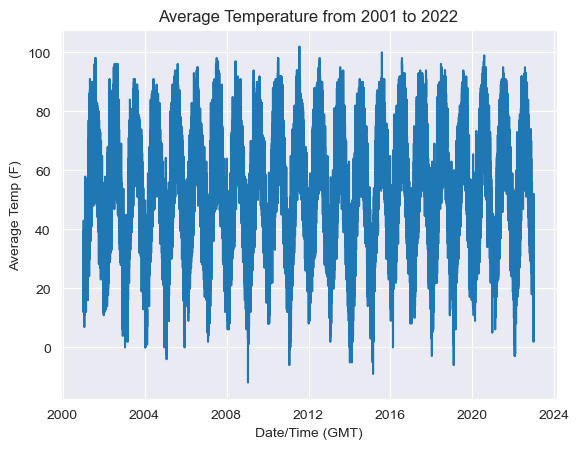

In [1921]:
# ANSWER

sns.lineplot(data=df_temps["Average Temp (F)"])
plt.title("Average Temperature from 2001 to 2022")
plt.show()

---
**34)**	[P] That previous plot is a bit ridiculous. You really need to aggregate your data over some time interval. The most meaningful one will be by year. Compute the mean of the hourly average temperature for each year plot this annual value. (HINT: The `resample()` method will again make this incredibly easy to do!)

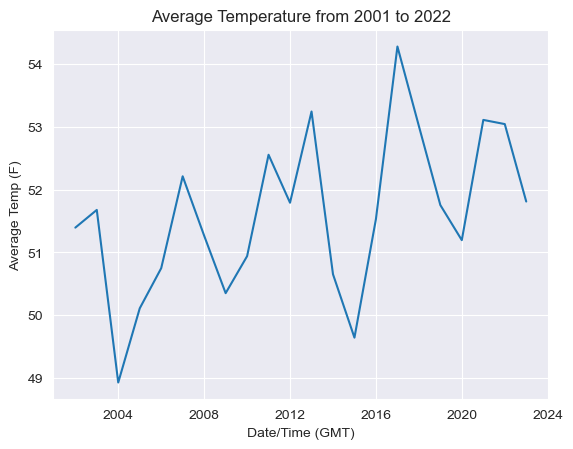

In [1922]:
# ANSWER

df_average_by_year = df_temps["Average Temp (F)"].resample('Y').mean()
sns.lineplot(data=df_average_by_year)
plt.title("Average Temperature from 2001 to 2022")
plt.show()

---
Congratulations! At this point, you performed your first real-world example of what you need to go through to complete basic preprocessing steps!

---
# Deliverables
1.	Be sure you have every cell run, and output generated.
2.	Commit and push `lab06.ipynb`. Verify that your file is pushed properly on Gitlab.
3.	Generate a paginated PDF file of your notebook and upload to Gradescope
4.	Be sure to select the pages that have the specified questions, and submit when done
